Instalar

In [1]:
#Para utilizar keras-core primero hay que instalar tensorflow o pytorch o jax
!pip install tensorflow

# una vez instalado nuestro backend podemos instalar keras-core
#Se recomienda correr el jupyter notebook en colab, ya que tiene acceso gratis a GPUS y también tiene ya instalado tensorflow, pytorch y jax, solo hace falta instalar keras-core.
!pip install -q keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 7.8 MB/s eta 0:00:00


In [9]:
# Instala la biblioteca Kaggle
!pip install -q kaggle

# Sube tu api key
from google.colab import files
files.upload()

# Crea un directorio para el archivo de configuración Kaggle y copia el archivo JSON de Kaggle
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descarga los datos de una competencia de Kaggle
!kaggle competitions download -c inf-395-tarea-1

# Descomprime
! unzip inf-395-tarea-1.zip

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
403 - Forbidden - Permission 'competitions.participate' was denied
unzip:  cannot find or open inf-395-tarea-1.zip, inf-395-tarea-1.zip.zip or inf-395-tarea-1.zip.ZIP.


In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

SEED = 42
keras.utils.set_random_seed(SEED)

In [ ]:
!mv /content/data_kaggle/data/test_data.csv /content/test_data.csv
!mv /content/data_kaggle/data/train_data.csv /content/train_data.csv

In [128]:
df_test = pd.read_csv('test_data.csv')
df_train = pd.read_csv('train_data.csv')

Imports

Funciones

In [143]:
def viz_imgs(imgs, labels):
  "Función para visualizar imágenes junto a sus labels"
  plt.figure(figsize=(10,10))
  random_inds = np.random.choice(imgs.shape[0],36)
  for i in range(36):
      plt.subplot(6,6,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      image_ind = random_inds[i]
      plt.imshow(np.squeeze(imgs[image_ind]), cmap=plt.cm.binary)
      plt.xlabel(labels[image_ind])
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
def plot_cm(y_pred, y_test):
  "Función para graficar matriz de confusión"
  cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
  cm_display = ConfusionMatrixDisplay(cm).plot()
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df
def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps

Desafío

In [144]:
df_train = pd.read_csv('train_data.csv')
df_train.head()

,ID,date,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,143,20140515T000000,98003,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,...,0.0,4.0,7.0,1590.0,0.0,1991.0,0.0,1590.0,7606.0,263000.0
1,1175,20141203T000000,98117,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,...,0.0,4.0,8.0,1740.0,300.0,1930.0,0.0,1380.0,4005.0,620000.0
2,221,20140711T000000,98106,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,...,0.0,3.0,6.0,640.0,0.0,1942.0,0.0,NaN,7424.0,165000.0
3,1231,20141117T000000,98144,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,...,0.0,NaN,8.0,1080.0,160.0,NaN,0.0,1530.0,1209.0,403000.0
4,509,20150402T000000,98038,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,...,NaN,3.0,7.0,1990.0,0.0,2010.0,0.0,2580.0,3800.0,318200.0


In [145]:
df_test = pd.read_csv('test_data.csv')
df_test

,ID,date,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,1473,20150421T000000,98006,47.5544,-122.147,NaN,4.50,4490.0,24767.0,2.0,0.0,2.0,3.0,NaN,3800.0,690.0,1998.0,0.0,3370.0,32700.0
1,716,20141029T000000,98030,47.3573,-122.200,3.0,NaN,1730.0,6007.0,NaN,0.0,0.0,NaN,8.0,NaN,0.0,NaN,0.0,2000.0,6245.0
2,1360,20141217T000000,98074,47.6085,-122.013,4.0,2.50,3720.0,8633.0,2.0,0.0,0.0,3.0,10.0,3720.0,0.0,1999.0,NaN,3515.0,9660.0
3,1522,20140715T000000,98027,47.4913,-122.081,4.0,2.50,2550.0,NaN,2.0,0.0,0.0,3.0,9.0,2550.0,0.0,2001.0,0.0,1870.0,56628.0
4,1570,20140825T000000,98146,47.4982,-122.362,1.0,0.75,480.0,9750.0,1.0,0.0,0.0,NaN,4.0,480.0,0.0,1948.0,0.0,1550.0,9924.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,1475,20141222T000000,98105,47.6706,-122.265,3.0,1.00,1710.0,NaN,1.0,0.0,0.0,3.0,7.0,1410.0,300.0,1946.0,0.0,1610.0,NaN
316,374,20140627T000000,98014,47.6622,-121.961,4.0,2.50,2770.0,63118.0,NaN,0.0,0.0,3.0,9.0,2770.0,0.0,1997.0,0.0,NaN,44224.0
317,795,20141205T000000,98077,47.7754,-122.032,3.0,NaN,NaN,219978.0,2.0,0.0,0.0,3.0,8.0,2130.0,0.0,NaN,0.0,3340.0,217800.0
318,888,20150331T000000,98056,47.4944,-122.165,3.0,1.00,960.0,5512.0,1.0,0.0,0.0,4.0,6.0,960.0,0.0,NaN,0.0,1090.0,5837.0


In [ ]:
datainfo(df_test)

# ZIPCODES (Incluir otro dataset con el ingreso)


In [130]:
# Descarga los datos de una competencia de Kaggle
!kaggle datasets download -d joshuafscott/median-household-income-by-zip-code-in-washington

# Descomprime
! unzip median-household-income-by-zip-code-in-washington.zip

median-household-income-by-zip-code-in-washington.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  median-household-income-by-zip-code-in-washington.zip
replace Census_Median_Income.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [131]:
zip_df = pd.read_csv('Census_Median_Income.csv')
zip_df = zip_df[['NAME', 'S1903_C03_001E']]
zip_df = zip_df.iloc[1:]
zip_df['NAME'] = zip_df['NAME'].str.extract(r'(\d+)$')
zip_df['NAME'] = pd.to_numeric(zip_df['NAME'], errors='coerce')
zip_df['S1903_C03_001E'] = pd.to_numeric(zip_df['S1903_C03_001E'], errors='coerce')
zip_df['S1903_C03_001E'] = zip_df['S1903_C03_001E'].fillna(zip_df['S1903_C03_001E'].mean())
datainfo(zip_df)

,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
NAME,int64,598,598,0,0.0
S1903_C03_001E,float64,598,541,0,0.0


# Eploración de la data

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'zipcode'}>,
        <Axes: title={'center': 'lat'}>,
        <Axes: title={'center': 'long'}>],
       [<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'sqft_living'}>,
        <Axes: title={'center': 'sqft_lot'}>],
       [<Axes: title={'center': 'floors'}>,
        <Axes: title={'center': 'waterfront'}>,
        <Axes: title={'center': 'view'}>,
        <Axes: title={'center': 'condition'}>],
       [<Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'sqft_above'}>,
        <Axes: title={'center': 'sqft_basement'}>,
        <Axes: title={'center': 'yr_built'}>],
       [<Axes: title={'center': 'yr_renovated'}>,
        <Axes: title={'center': 'sqft_living15'}>,
        <Axes: title={'center': 'sqft_lot15'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

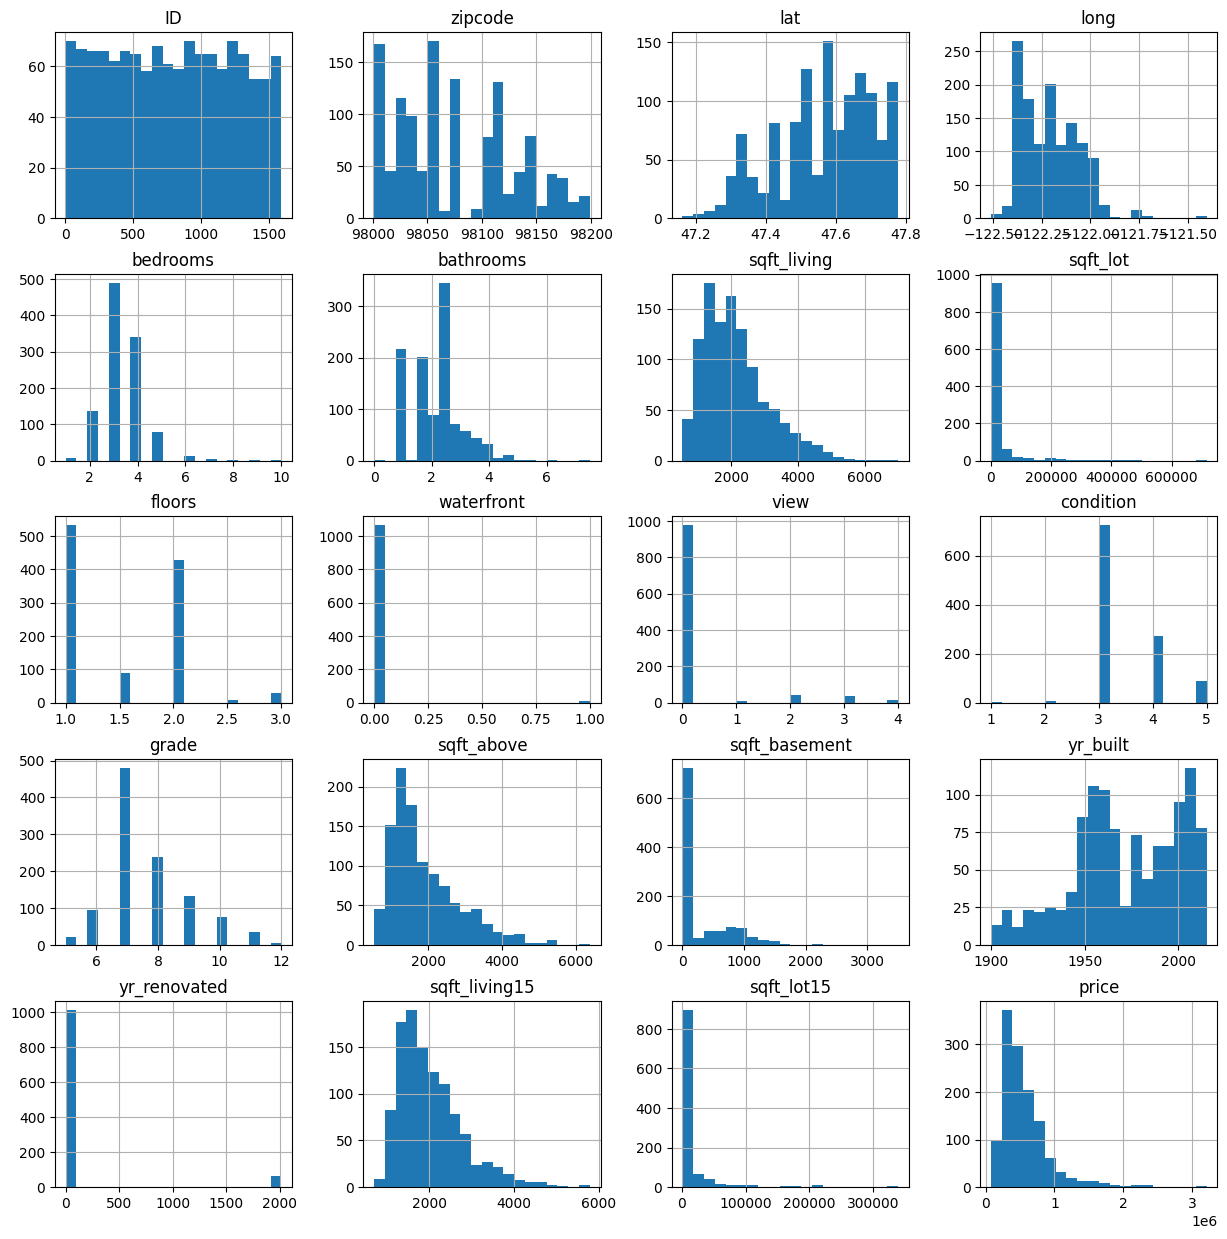

In [133]:
df_train.hist(figsize=(15,15), layout=(5,4), bins=20)

In [ ]:
df_train.plot(kind="box",subplots=True,layout=(5,5),figsize=(15,15))

<ipython-input-66-0412b63ead0c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr= df_train.corr()


<Axes: >

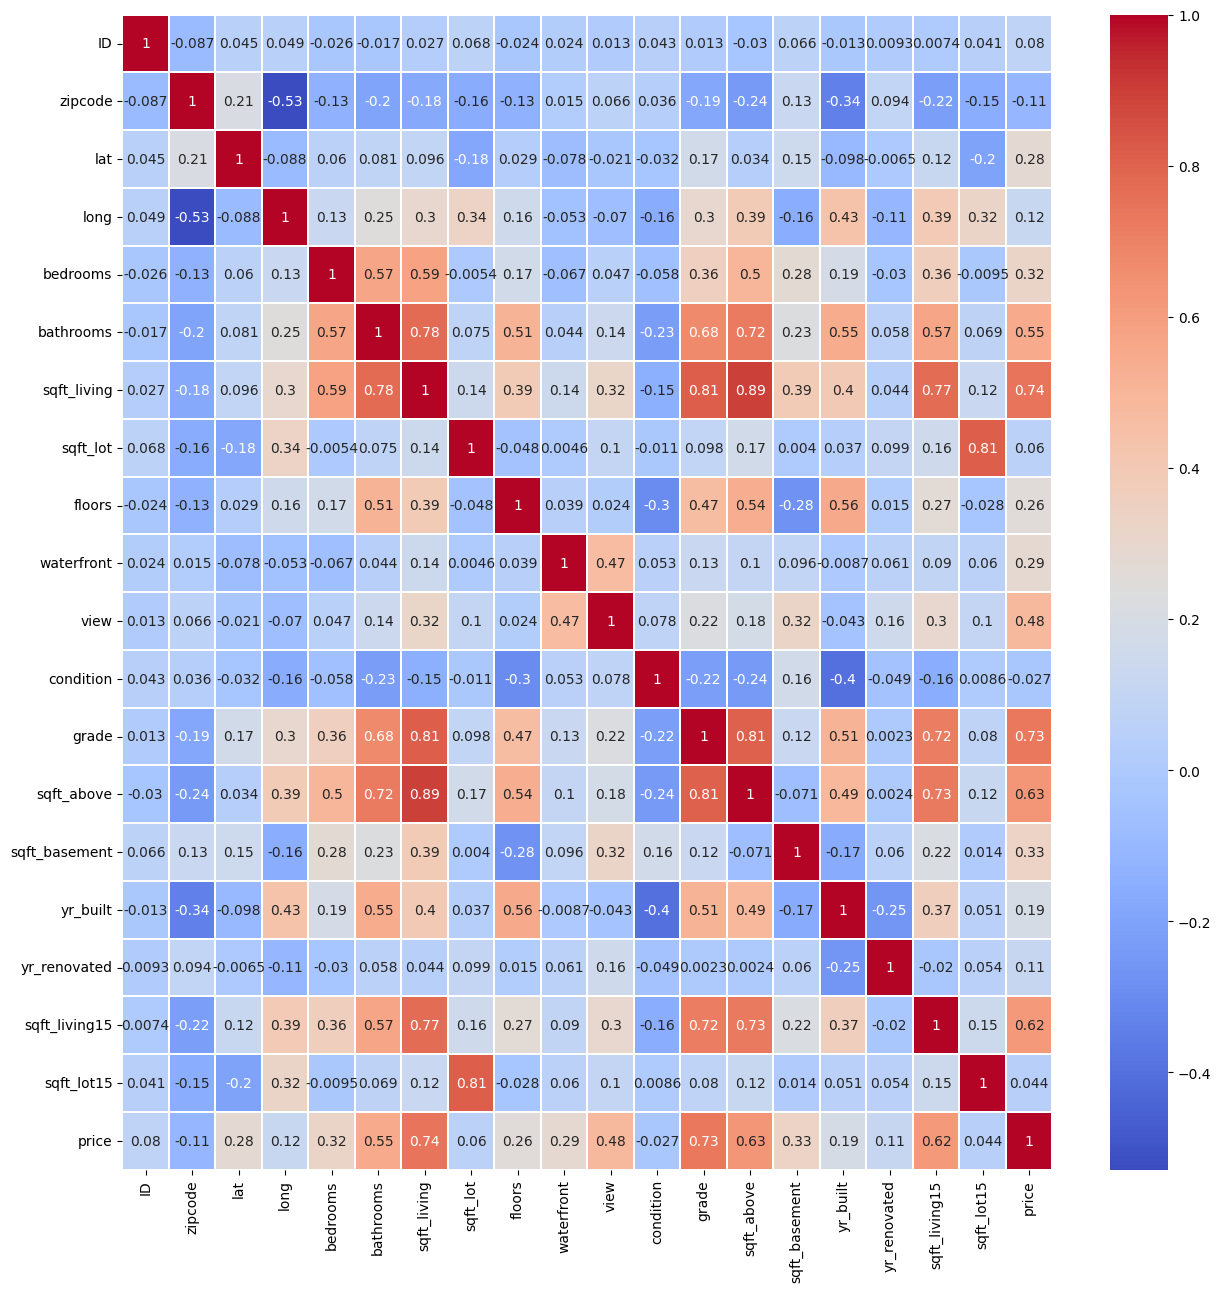

In [66]:
data_corr= df_train.corr()
plt.figure(figsize=(15,15))

sns.heatmap(data_corr, cmap='coolwarm', linewidths=0.1, annot=True, linecolor='white')

In [153]:
def corrections_df(df_train, df_processed):
  df_train_median_bedrooms = df_train['bedrooms'].median()
  df_train_median_bathrooms = df_train['bathrooms'].median()
  df_train_median_sqft_living = df_train['sqft_living'].median()
  df_train_median_sqft_lot = df_train['sqft_lot'].median()
  df_train_mean_floors = df_train['floors'].mean()
  df_train_mean_waterfront = df_train['waterfront'].mean()
  df_train_mean_view = df_train['view'].mean()
  df_train_mean_condition = df_train['condition'].mean()
  df_train_mean_grade = df_train['grade'].mean()
  df_train_mean_sqft_above = df_train['sqft_above'].mean()
  df_train_mean_sqft_basement = df_train['sqft_basement'].mean()
  df_train_mean_yr_built = df_train['yr_built'].mean()
  df_train_mean_yr_renovated = df_train['yr_renovated'].mean()
  df_train_median_sqft_living15 = df_train['sqft_living15'].median()
  df_train_median_sqft_lot15 = df_train['sqft_lot15'].median()

  #df_train['bedrooms'] = df_train['bedrooms'].fillna(df_train_mean_bedrooms)
  #df_train['bathrooms'] = df_train['bathrooms'].fillna(df_train_mean_bathrooms)
  df_processed['sqft_living'] = df_processed['sqft_living'].fillna(df_train_median_sqft_living)
  df_processed['sqft_lot'] = df_processed['sqft_lot'].fillna(df_train_median_sqft_lot)
  df_processed['floors'] = df_processed['floors'].fillna(df_train_mean_floors)
  df_processed['waterfront'] = df_processed['waterfront'].fillna(0) # df_train_mean_waterfront
  df_processed['view'] = df_processed['view'].fillna(df_train_mean_view)
  df_processed['condition'] = df_processed['condition'].fillna(df_train_mean_condition)
  df_processed['grade'] = df_processed['grade'].fillna(df_train_mean_grade)
  df_processed['sqft_above'] = df_processed['sqft_above'].fillna(df_train_mean_sqft_above)
  df_processed['sqft_basement'] = df_processed['sqft_basement'].fillna(df_train_mean_sqft_basement)
  df_processed['yr_built'] = df_processed['yr_built'].fillna(df_train_mean_yr_built)
  df_processed['sqft_living15'] = df_processed['sqft_living15'].fillna(df_train_median_sqft_living15)
  df_processed['sqft_lot15'] = df_processed['sqft_lot15'].fillna(df_train_median_sqft_lot15)

  # Replace 0 and NaN values in 'yr_renovated' with values from 'yr_built'
  mask = (df_processed['yr_renovated'] == 0) | df_processed['yr_renovated'].isna()
  df_processed.loc[mask, 'yr_renovated'] = df_processed['yr_built']

  # Reemplazar bathrooms y bedrooms en base al valor de la otra columna
  mask2 =  df_processed['bathrooms'].isna()
  df_processed.loc[mask2, 'bathrooms'] = df_processed['bedrooms'] - 1

  mask3 =  df_processed['bedrooms'].isna()
  df_processed.loc[mask3, 'bedrooms'] = df_processed['bathrooms'] - 1

  # Reemplazar el resto de nans con la mediana
  df_processed['bedrooms'] = df_processed['bedrooms'].fillna(df_train_median_bedrooms)
  df_processed['bathrooms'] = df_processed['bathrooms'].fillna(df_train_median_bathrooms)
  return df_processed

In [157]:
df_train = corrections_df(pd.read_csv('train_data.csv'), pd.read_csv('train_data.csv'))
df_test = corrections_df(pd.read_csv('train_data.csv'), pd.read_csv('test_data.csv'))

In [156]:
def scale_years(df, toFit, scaler):
    num, den = scaler
    if (toFit):
      num = - df['yr_built'].min()
      den = df['yr_built'].max() - df['yr_built'].min()

    df['yr_built'] = (df['yr_built'] + num) / den
    df['yr_renovated'] = (df['yr_renovated'] + num) / den

    return (df, (num, den))

def post_transformacion_universal(df, toFit, scaler, yrScaler = (0,0), isTrain = False):
  if (isTrain):
    df = df.drop('ID', axis=1)

  # Tiempos
  if (False):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%dT000000')
    date = df['date']
    df['day'] = date.dt.day
    df['day of week'] = date.dt.dayofweek
    df['month'] = date.dt.month
    df['year'] = date.dt.year
    df = df.drop('date', axis=1)
    # time conversion
    df = preprocess_time(df, "day of week", 7)
    df = preprocess_time(df, "month", 12)
    df = preprocess_time(df, "day", 30)
  else:
    df = df.drop('date', axis=1)

  # Geography
  #df['lat'] = df['lat'] + 180
  #df = preprocess_time(df, "lat", 360)
  #df['long'] = df['long'] + 180
  #df = preprocess_time(df, "long", 360)

  # Zipcodes
  df = df.merge(zip_df, left_on='zipcode', right_on='NAME', how='left')
  df = df.drop('NAME', axis=1)
  df = df.drop('zipcode', axis=1)
  df.rename(columns={'S1903_C03_001E': 'income'}, inplace=True)

  # Create a MinMaxScaler
  cols_to_normalize = [
                      'bedrooms',
                      'bathrooms',
                      'sqft_living',
                      'sqft_lot',
                      'floors',
                      'sqft_above',
                      'sqft_basement',
                      #'yr_built',
                      #'yr_renovated',
                      'sqft_living15',
                      'sqft_lot15',

                      #'sin_lat',
                      #'cos_lat',
                      #'sin_long',
                      #'cos_long',
                      'lat',
                      'long',

                      'condition',
                      'view',
                      'grade',

                      'income',
                      ]
  if (toFit):
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
  else:
    df[cols_to_normalize] = scaler.transform(df[cols_to_normalize])

  df, yrScaler = scale_years(df, toFit, yrScaler)

  return (df, yrScaler)


In [150]:
df = df_train
X = df.drop('price',axis=1)
y = df['price']

X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_test, X_val, Y_test, Y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=SEED)

In [158]:
#scaler = MinMaxScaler((-1,1))
scaler = StandardScaler()

X_train, yrScaler = post_transformacion_universal(X_train, True, scaler, (0,0), True)
X_test, _ = post_transformacion_universal(X_test, False, scaler, yrScaler, True)
X_val, _ = post_transformacion_universal(X_val, False, scaler, yrScaler, True)

df_test, _ = post_transformacion_universal(df_test, False, scaler, yrScaler, False)

Text(0.5, 1.0, 'Mutual information between predictors and target')

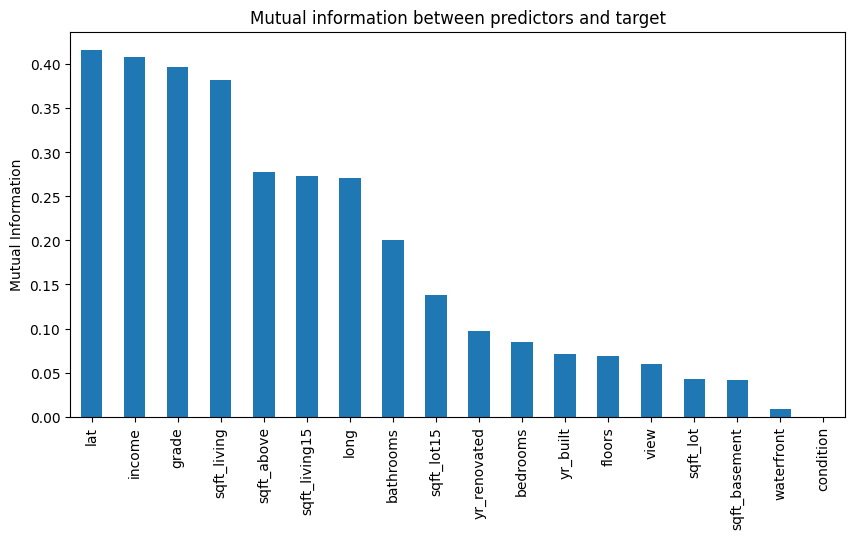

In [160]:
mi = mutual_info_regression(X_train, Y_train)
mi = pd.Series(mi)

mi.index = X_train.columns
mi.sort_values(ascending=False).plot.bar(figsize=(10, 5))
plt.ylabel('Mutual Information')
plt.title("Mutual information between predictors and target")

In [184]:
# Número de features a elegir
n = len(mi) - 5

# Sort de los features respecto a su mi score
sorted_indices = np.argsort(mi)

# Se eligen las mejores n
selected_indices = sorted_indices[-n:]

# Se eliminan las peores features y se mantienen las mejores n
no_selected_indices = (sorted_indices[:-n]).tolist()
X_train_mi = X_train.drop(X_train.columns[no_selected_indices], axis=1)
X_test_mi = X_test.drop(X_test.columns[no_selected_indices], axis=1)
X_val_mi = X_val.drop(X_val.columns[no_selected_indices], axis=1)

# MODELO

In [185]:
### START CODE HERE ###
epochs = 200
batch_size =  64
#val_split = 0.1
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=50,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
] #si va a implementar early stopping, asegurese de retornar los mejores pesos

In [186]:
inputs = keras.layers.Input(shape=(X_train_mi.shape[1],))
x1 = keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(inputs)
x1 = keras.layers.Dropout(0.2)(x1)
x1 = keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x1)
x1 = keras.layers.Dropout(0.2)(x1)
x1 = keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x1)
x1 = keras.layers.Dropout(0.2)(x1)
x1 = keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x1)
x1 = keras.layers.Dropout(0.2)(x1)
x1 = keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x1)
x1 = keras.layers.Dropout(0.2)(x1)
x1 = keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x1)
x1 = keras.layers.Dropout(0.2)(x1)
output = keras.layers.Dense(1, activation='relu')(x1)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 13)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_113 (Dense)               │ (None, 512)               │      7,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_92 (Dropout)            │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_114 (Dense)               │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_93 (Dropout)            │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_115 (Dense)               │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_94 (Dropout)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_116 (Dense)               │ (None, 512)               │     66,048 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_95 (Dropout)            │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_117 (Dense)               │ (None, 512)               │    262,656 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_96 (Dropout)            │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_118 (Dense)               │ (None, 128)               │     65,664 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_97 (Dropout)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_119 (Dense)               │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 565,889 (2.16 MB)

 Trainable params: 565,889 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [187]:
loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=10**-2.3)
# "accuracy"
model.compile(optimizer=opt, loss=loss, metrics=["mean_squared_error", "mean_absolute_error", "root_mean_squared_error"])

history = model.fit(X_train_mi,
                    Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_mi,Y_val),
                    shuffle = True,
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 400356162620.2353 - mean_absolute_error: 512538.0460 - mean_squared_error: 400443356340.7059 - root_mean_squared_error: 631193.4375 - val_loss: 230634307584.0000 - val_mean_absolute_error: 336667.6250 - val_mean_squared_error: 230634307584.0000 - val_root_mean_squared_error: 480244.0000
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 168571546925.1765 - mean_absolute_error: 297690.4853 - mean_squared_error: 168605404943.0588 - root_mean_squared_error: 409371.0735 - val_loss: 135684136960.0000 - val_mean_absolute_error: 231264.6562 - val_mean_squared_error: 135684136960.0000 - val_root_mean_squared_error: 368353.2812
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 102164895864.4706 - mean_absolute_error: 219360.7638 - mean_squared_error: 102183956239.0588 - root_mean_squared_error: 319241.9228 - val_loss: 105658433536.0000 - val_mean_absolute_error: 189709.0625 - val_mean_squared_error: 105658433536.000

# end

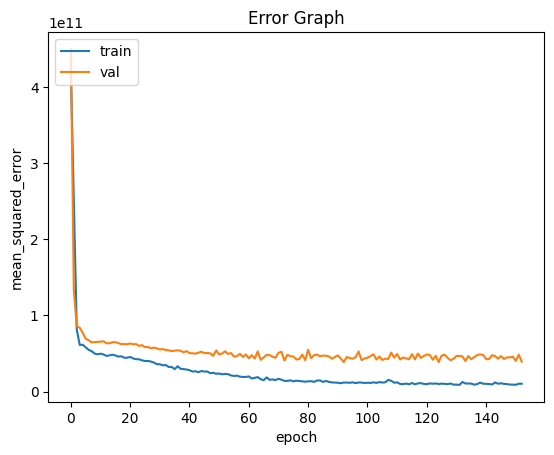

In [165]:
plot_losses(history, loss)

In [166]:
score = model.evaluate(X_test_new, Y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print()

final_mse = history.history['mean_squared_error'][-1]
print(f"Final Mean Squared Error: {final_mse}")

print("kagle: ", final_mse/15607008361.30020)

print("Si esto es positivo, bien! ", 15607008361.30020 - final_mse)

Test loss: 35626901504.0
Test accuracy: 115235.7890625

Final Mean Squared Error: 10423379968.0
kagle:  0.667865341435086
Si esto es positivo, bien!  5183628393.3001995


In [37]:
# Save the model to a file
model.save('/content/rn_t1.keras')

In [38]:
from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model.save('/content/drive/My Drive/rn_t1.keras')

MessageError: ignored

In [39]:
new_df_test = df_test.drop('ID', axis=1)
results =  pd.DataFrame(model.predict(new_df_test))

# Define the file path where you want to save the .csv file
file_path = '/content/results.csv'

# Save the predictions to a .csv file
results.to_csv(file_path, index=False)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


In [40]:
file = open('a.csv', "w")
file.write("ID, price\n")
for i in range(len(df_test['ID'])):
    file.write(str(df_test['ID'][i]) + "," + str(results[0][i]) + "\n")
file.close()